# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [1]:
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
import scipy
import data_converter as dst
%matplotlib inline

/home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

In [2]:
curr_data_set = dst.get_dblp_data_set()
count_data = len(curr_data_set["data"])
count_labels = len(curr_data_set["labels"])
raw_labels = [0 if float(label_elem) < 0  else 1 for label_elem in curr_data_set["labels"]]
assert count_data == count_labels
count_value_labels = len(curr_data_set["label_values"])
for matr in curr_data_set["data"]:
    assert len(curr_data_set["data"][0]) == len(matr)

X_not_full = np.asarray(curr_data_set["data"])
X = X_not_full.reshape((X_not_full.shape[0], X_not_full.shape[1] * X_not_full.shape[2]))
y = np.asarray(raw_labels)

print(count_data)
print(count_labels)
print(curr_data_set["label_values"])
print(X.shape)
print(y.shape)

d = X.shape[1]   # Dimensionality.
n = X.shape[0]   # Number of samples.
c = count_labels # Number of feature communities.

19456
19456
{'-1.0', '1.0'}
(19456, 1521)
(19456,)


Then split this dataset into training, validation and testing sets.

In [3]:
n_train = n // 2
n_val = n // 10

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

d = |V| = 1521, k|V| < |E| = 28928


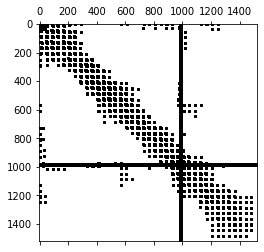

In [4]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.spy(A, markersize=2, color='black');

To be able to pool graph signals, we need first to coarsen the graph, i.e. to find which vertices to group together. At the end we'll have multiple graphs, like a pyramid, each at one level of resolution. The finest graph is where the input data lies, the coarsest graph is where the data at the output of the graph convolutional layers lie. That data, of reduced spatial dimensionality, can then be fed to a fully connected layer.

The parameter here is the number of times to coarsen the graph. Each coarsening approximately reduces the size of the graph by a factor two. Thus if you want a pooling of size 4 in the first layer followed by a pooling of size 2 in the second, you'll need to coarsen $\log_2(4+2) = 3$ times.

After coarsening we rearrange the vertices (and add fake vertices) such that pooling a graph signal is analog to pooling a 1D signal. See the [paper] for details.

[paper]: https://arxiv.org/abs/1606.09375

In [5]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=True)

X_train = coarsening.perm_data(X_train, perm)
print(X_train.shape)
X_val = coarsening.perm_data(X_val, perm)
print(X_val.shape)
X_test = coarsening.perm_data(X_test, perm)
print(X_test.shape)

/home/anesterov/Documents/science/source/cnn_graph/lib/coarsening.py:152: RuntimeWarning: divide by zero encountered in true_divide
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])


Layer 0: M_0 = |V| = 8984 nodes (7463 added),|E| = 14276 edges
Layer 1: M_1 = |V| = 4492 nodes (3162 added),|E| = 13054 edges
Layer 2: M_2 = |V| = 2246 nodes (1039 added),|E| = 12219 edges
Layer 3: M_3 = |V| = 1123 nodes (0 added),|E| = 11343 edges
(9728, 8984)
(1945, 8984)
(7783, 8984)


We finally need to compute the graph Laplacian $L$ for each of our graphs (the original and the coarsened versions), defined by their adjacency matrices $A$. The sole parameter here is the type of Laplacian, e.g. the combinatorial Laplacian, the normalized Laplacian or the random walk Laplacian.

/home/anesterov/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


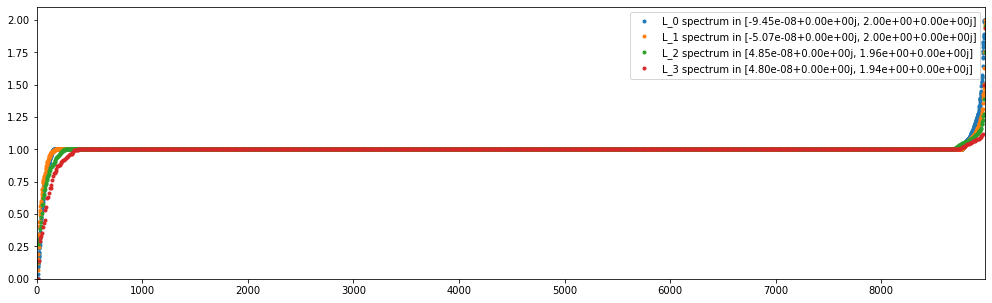

In [6]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [7]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 15
params['batch_size']     = 100
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['brelu']          = 'b2relu'
params['pool']           = 'apool1'
params['pool']           = 'mpool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [15, 15]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [10, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0
params['decay_steps']    = n_train / params['batch_size']

In [8]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

W0913 12:59:47.262305 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:156: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 12:59:47.267344 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:955: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0913 12:59:47.274327 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:889: The name tf.sparse_reorder is deprecated. Please use tf.sparse.reorder instead.

W0913 12:59:47.282886 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:898: The name tf.sparse_tensor_dense_matmul is deprecated. Please use tf.sparse.sparse_dense_matmul instead.

W0913 12:59:47.350806 140635453314880 deprecation_wrapper.py:119] From /ho

NN architecture
  input: M_0 = 8984
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 8984 * 15 / 4 = 33690
    weights: F_0 * F_1 * K_1 = 1 * 15 * 10 = 150
    biases: M_1 * F_1 = 8984 * 15 = 134760
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 2246 * 15 / 2 = 16845
    weights: F_1 * F_2 * K_2 = 15 * 15 * 10 = 2250
    biases: M_2 * F_2 = 2246 * 15 = 33690
  layer 3: fc1
    representation: M_3 = 10
    weights: M_2 * M_3 = 16845 * 10 = 168450
    biases: M_3 = 10
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 10 * 2 = 20
    biases: M_4 = 2


W0913 12:59:47.476504 140635453314880 deprecation.py:506] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:969: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0913 12:59:47.501235 140635453314880 deprecation.py:323] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:209: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0913 12:59:47.508078 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/cnn_graph/lib/models.py:217: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0913 12:59:47.553595 140635453314880 deprecation_wrapper.py:119] From /home/anesterov/Documents/science/source/c

step 100 / 1459 (epoch 1.03 / 15):
  learning_rate = 9.50e-04, loss_average = 9.54e-01
  validation accuracy: 61.39 (1194 / 1945), f1 (weighted): 56.57, loss: 9.56e-01
  time: 242s (wall 88s)
step 200 / 1459 (epoch 2.06 / 15):
  learning_rate = 9.03e-04, loss_average = 8.91e-01
  validation accuracy: 79.74 (1551 / 1945), f1 (weighted): 79.48, loss: 9.02e-01
  time: 485s (wall 176s)
step 300 / 1459 (epoch 3.08 / 15):
  learning_rate = 8.57e-04, loss_average = 8.41e-01
  validation accuracy: 78.82 (1533 / 1945), f1 (weighted): 78.80, loss: 8.77e-01
  time: 732s (wall 265s)
step 400 / 1459 (epoch 4.11 / 15):
  learning_rate = 8.15e-04, loss_average = 8.38e-01
  validation accuracy: 79.69 (1550 / 1945), f1 (weighted): 79.69, loss: 8.65e-01
  time: 985s (wall 361s)
step 500 / 1459 (epoch 5.14 / 15):
  learning_rate = 7.74e-04, loss_average = 7.99e-01
  validation accuracy: 79.90 (1554 / 1945), f1 (weighted): 79.89, loss: 8.57e-01
  time: 1238s (wall 457s)
step 600 / 1459 (epoch 6.17 / 15):


W0913 13:09:01.890108 140635453314880 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


step 700 / 1459 (epoch 7.20 / 15):
  learning_rate = 6.98e-04, loss_average = 8.08e-01
  validation accuracy: 80.26 (1561 / 1945), f1 (weighted): 80.26, loss: 8.47e-01
  time: 1744s (wall 645s)
step 800 / 1459 (epoch 8.22 / 15):
  learning_rate = 6.63e-04, loss_average = 8.27e-01
  validation accuracy: 80.26 (1561 / 1945), f1 (weighted): 80.26, loss: 8.47e-01
  time: 1995s (wall 736s)
step 900 / 1459 (epoch 9.25 / 15):
  learning_rate = 6.30e-04, loss_average = 7.92e-01
  validation accuracy: 80.36 (1563 / 1945), f1 (weighted): 80.37, loss: 8.44e-01
  time: 2247s (wall 828s)
step 1000 / 1459 (epoch 10.28 / 15):
  learning_rate = 5.99e-04, loss_average = 7.86e-01
  validation accuracy: 80.05 (1557 / 1945), f1 (weighted): 80.05, loss: 8.39e-01
  time: 2499s (wall 920s)
step 1100 / 1459 (epoch 11.31 / 15):
  learning_rate = 5.69e-04, loss_average = 8.05e-01
  validation accuracy: 80.10 (1558 / 1945), f1 (weighted): 80.11, loss: 8.39e-01
  time: 2756s (wall 1018s)
step 1200 / 1459 (epoch 1

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

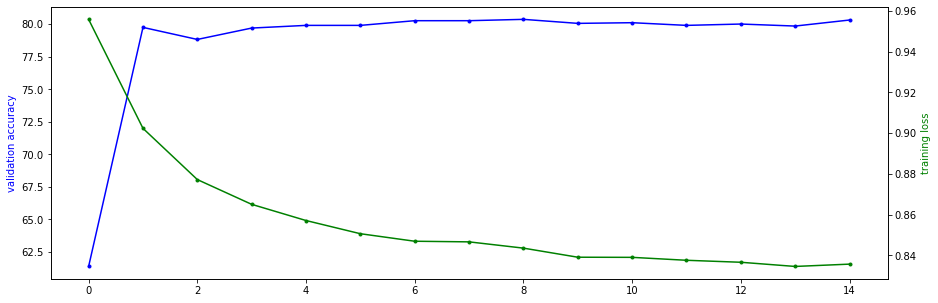

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [10]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 938.17 ms


In [11]:
res = model.evaluate(X_test, y_test)
print(res[0])

W0913 13:22:36.962437 140635453314880 deprecation.py:323] From /home/anesterov/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


accuracy: 79.46 (6184 / 7783), f1 (weighted): 79.45, loss: 7.93e-01
time: 81s (wall 33s)
